In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [331]:
df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)
sample_info['total_counts'] = df.sum(1)
sample_info = sample_info.query('total_counts > 5')
df = df.loc[sample_info.index]
dfm = np.log10(df + 1)

In [493]:
cpm = ((df.T + 1) / (df.sum(1) + 1)).T * 1e6
lcpm = np.log10(cpm)

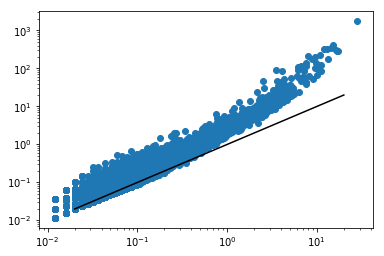

In [691]:
plt.loglog()
plt.scatter(df.mean(), df.var());
xx = [2e-2, 2e1]
plt.plot(xx, xx, c='k');

In [692]:
from scipy import optimize

In [784]:
phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, df.mean(), df.var())

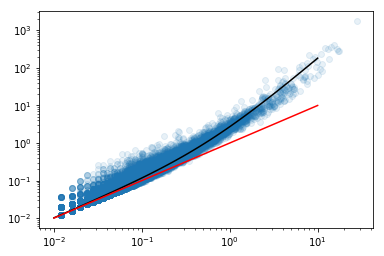

In [787]:
plt.loglog()
plt.scatter(df.mean(), df.var(), alpha=0.1);
xx = np.logspace(-2, 1)
plt.plot(xx, xx + phi_hat * xx ** 2, c='k');
plt.plot(xx, xx, c='r');

In [773]:
def nb_anscombe(a, phi):
    return np.log(a + 1 / (2 * phi))

In [774]:
nb_adf = nb_anscombe(df, phi_hat[0])

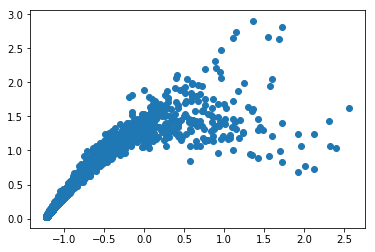

In [830]:
# plt.loglog()
plt.scatter(nb_adf.mean(), nb_adf.var());

In [788]:
import NaiveDE

In [789]:
sample_info['ans_total_counts'] = nb_anscombe(sample_info.total_counts, phi_hat[0])

In [790]:
res = NaiveDE.regress_out(sample_info, nb_adf.T, 'ans_total_counts').T

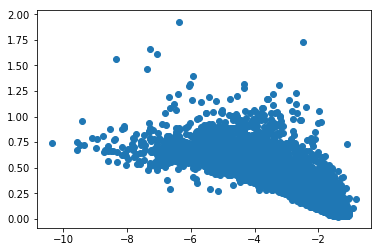

In [793]:
plt.scatter(res.mean(), res.var());

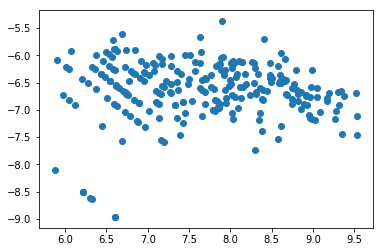

In [799]:
plt.scatter(sample_info.ans_total_counts, res['EEF1A1']);

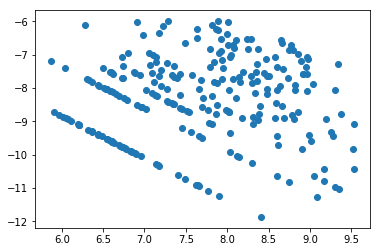

In [800]:
plt.scatter(sample_info.ans_total_counts, res['FN1']);

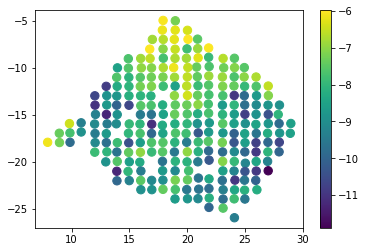

In [801]:
figsize(6, 4)
plt.scatter(sample_info.x, -sample_info.y, c=res['FN1'], s=70);
plt.colorbar();

In [802]:
import SpatialDE

In [803]:
results = SpatialDE.run(sample_info[['x', 'y']], res)

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.073s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                                
INFO:root:Model 3 of 10                                
INFO:root:Model 4 of 10                                
INFO:root:Model 5 of 10                                
INFO:root:Model 6 of 10                               
INFO:root:Model 7 of 10                                
INFO:root:Model 8 of 10                               
INFO:root:Model 9 of 10                               
INFO:root:Model 10 of 10                               
INFO:root:Simulating 10000 null models                 
INFO:root:Done: 1.2s
INFO:root:Performing DE test on null models
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.076s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                               
INFO:root:Model 3 of 10                               
I

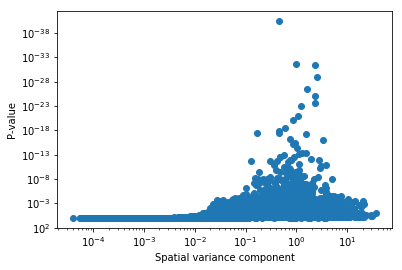

In [810]:
figsize(6, 4)
plt.loglog()
plt.scatter(results.max_s2_t_hat, results.pval);
plt.gca().invert_yaxis();
plt.xlabel('Spatial variance component')
plt.ylabel('P-value');

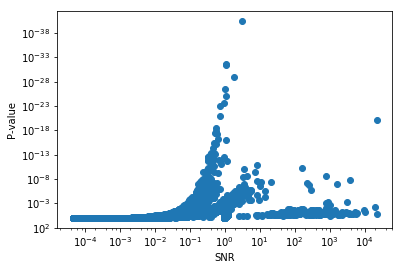

In [811]:
plt.loglog()
plt.scatter(1./results.max_delta, results.pval);
plt.gca().invert_yaxis();
plt.xlabel('SNR')
plt.ylabel('P-value');

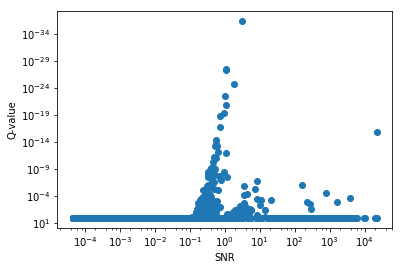

In [812]:
plt.loglog()
plt.scatter(1./results.max_delta, results.qval);
plt.gca().invert_yaxis();
plt.xlabel('SNR')
plt.ylabel('Q-value');

In [813]:
results.query('qval < 0.05').shape

(159, 15)

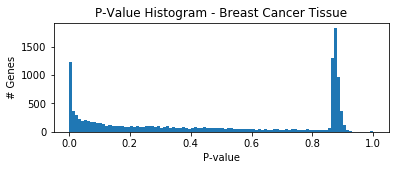

In [808]:
figsize(6, 2)
plt.hist(results.pval, bins=100);
plt.title('P-Value Histogram - Breast Cancer Tissue')
plt.ylabel('# Genes')
plt.xlabel('P-value');

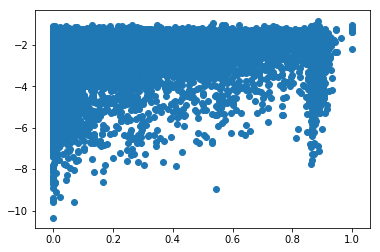

In [823]:
plt.scatter(results.pval, res[results.g].mean())

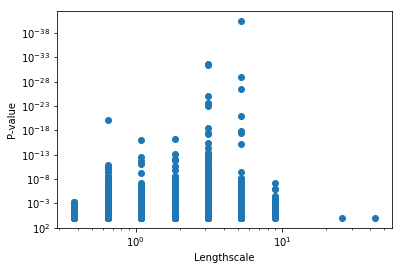

In [814]:
plt.loglog()
plt.scatter(results.l, results.pval);
plt.gca().invert_yaxis();
plt.xlabel('Lengthscale')
plt.ylabel('P-value');

In [815]:
N = 5
top_per_ls = results.query('qval < 0.05') \
                  .sort_values('qval', ascending=True) \
                  .groupby('l') \
                  .head(N) \
                  .sort_values(['l', 'qval'], ascending=[True, True])
                
top_per_ls

,g,max_delta,max_ll_x,max_mu_hat,max_s2_t_hat,n,time,l,M,model,BIC,max_ll_y,D,pval,qval
3384,SNAP25,0.000045,111.715660,-1.371640,0.838213,250,0.000341,0.641736,4,SE,-201.345476,67.168507,44.547153,8.755084e-21,1.125554e-16
2852,HMGCS2,0.123202,-185.475656,-2.957341,3.824079,250,0.001421,0.641736,4,SE,393.037155,-208.658794,23.183138,1.348735e-11,1.733933e-07
2973,SSPO,0.006145,96.077259,-1.264141,0.717902,250,0.000625,0.641736,4,SE,-170.068674,74.356307,21.720952,5.812914e-11,7.473082e-07
3606,ZNF880,0.286941,88.645226,-1.390789,0.760491,250,0.000763,0.641736,4,SE,-155.204608,67.469764,21.175461,1.003233e-10,1.289756e-06
2922,ETV7,0.132789,36.493602,-1.470170,0.920390,250,0.000820,0.641736,4,SE,-50.901360,16.678220,19.815382,3.918774e-10,5.037976e-06
5643,TGM2,0.892186,-309.026342,-4.469067,3.334742,250,0.000538,1.087806,4,SE,640.138527,-344.250242,35.223901,8.666177e-17,1.114124e-12
7839,CXCL13,1.030133,-84.166816,-1.707217,0.479068,250,0.000471,1.087806,4,SE,190.419476,-111.245366,27.078549,2.783949e-13,3.579045e-09
8279,IL12RB1,0.838752,126.514549,-1.397183,0.298408,250,0.000534,1.087806,4,SE,-230.943253,101.483508,25.031040,2.136198e-12,2.746296e-08
5456,CXCL9,1.279886,-204.397476,-2.651728,1.106383,250,0.000530,1.087806,4,SE,430.880796,-227.988528,23.591052,8.976910e-12,1.154072e-07
7083,FGG,1.542044,-180.864710,-1.972085,0.618055,250,0.000640,1.087806,4,SE,383.815263,-200.528249,19.663539,4.563431e-10,5.866747e-06


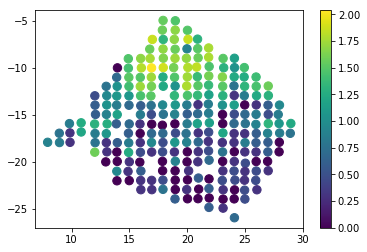

In [816]:
figsize(6, 4)
plt.scatter(sample_info.x, -sample_info.y, c=dfm['COL1A1'], s=70);
plt.colorbar();

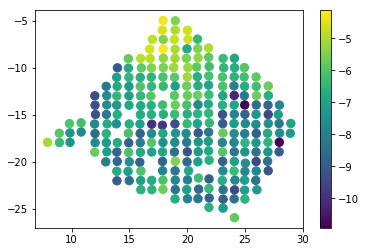

In [817]:
figsize(6, 4)
plt.scatter(sample_info.x, -sample_info.y, c=res['COL1A1'], s=70);
plt.colorbar();